In [12]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math as m
from scipy.stats import wasserstein_distance

def heat_v(states):
    arr = states
    df = pd.DataFrame(np.nan, index=np.arange(0, 21), columns=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    #df = df.fillna(-1)
    z = df.to_numpy()
    ds = pd.DataFrame(arr, columns=['Q', 'T', 'x'])
    h = ds.groupby(['Q', 'T']).mean().reset_index()
    a = h.to_numpy()

    for i in range(31):  # Maximum inventory is 20
        for ii in range(0, 11):  # Maximum time is 5
            for iii in range(len(a)):
                if i == a[iii, 0] and ii == a[iii, 1]:
                    z[int(i), int(ii)] = a[iii, 2]
    sns.heatmap(z, cmap="YlGnBu")
    plt.xlabel('Time')
    plt.ylabel('Inventory') 
    plt.title('Heatmap of the average action per inventory and time step')
    plt.show()

def column_min_max_normalize(matrix, min, max):#, data
    """
    Normalizes a matrix of real numbers between 1 and -1 domain using min-max normalization.
    """
    # Find the minimum and maximum values for each column
    #scaler = pre.MinMaxScaler(feature_range=(-1, 1)).fit(matrix)
    min_vals = min#np.min(matrix, axis=0)#np.min(data)#
    max_vals = max#np.max(matrix, axis=0)#np.max(data)#
    range_vals = max_vals - min_vals
    
    # Perform column-wise min-max normalization
    normalized_matrix = 2 * (matrix - min_vals) / range_vals - 1
    
    if normalized_matrix.shape != ():
        for i in range(normalized_matrix.shape[0]):
            for ii in range(normalized_matrix.shape[1]):
                if normalized_matrix[i,ii] > 1: normalized_matrix[i,ii] = 1
                elif normalized_matrix[i,ii] <-1: normalized_matrix[i,ii] = -1

    return normalized_matrix 

def heatAct(data, min, max):

    n = 101
    #data = mu0qtp
    FILLER = -1
    def heatdn(states, thr1, thr2, h_min, h_max):
        arr = states
        df = pd.DataFrame(np.nan, index=np.arange(-1,n), columns=['1', '2', '3', '4', '5','6','7','8','9','10'])
        df = df.fillna(np.nan)
        z = df.to_numpy()#np.zeros((21,5))
        ds = pd.DataFrame(arr,columns=['Q', 'T', 'p', 'x'])
        ds['p'] = ds['p'].apply(column_min_max_normalize, args=(h_min, h_max))
        h = ds.where(ds['p'] >= thr1).where(ds['p'] <= thr2).groupby(['Q','T','p']).mean().reset_index()
        a = h.to_numpy()
        for i in range(n): #mx 20
            for ii in range(10): #mx 5
                for iii in range(len(a[:])):
                    if i == a[:,0][iii] and ii == a[:,1][iii]:
                        z[int(i),int(ii)] = a[iii,3]
        return z    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 20))

    # Loop through each subplot and generate a heatmap for it
    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    cmap.set_bad((1,1,0.7))
    #ns.heatmap(z, cmap=cmap)
    for i in range(2):
        for j in range(2):
            if i == 0 and j == 0:

                ax = sns.heatmap(heatdn(data,-0.75  ,-0.5, min,  max), ax=axs[i,j], cmap=cmap)
                ax.set_title('$-1 \leq \\bar{S} \leq -0.5$')#                

            elif i == 0 and j == 1:
                ax =sns.heatmap(heatdn(data,-0.5  ,0, min,  max), ax=axs[i,j],  cmap=cmap)
                ax.set_title('$-0.5 \leq \\bar{S} \leq 0$')#
            elif i == 1 and j == 0:
                ax =sns.heatmap(heatdn(data,0  ,0.5, min,  max), ax=axs[i,j],   cmap=cmap)
                ax.set_title('$0 \leq \\bar{S} \leq 0.5$')#
            else:
                ax =sns.heatmap(heatdn(data,0.5  ,0.75, min,  max), ax=axs[i,j],   cmap=cmap)
                ax.set_title('$0.5 \leq \\bar{S} \leq 1$')#
            #for h in range(len(q)):
            #    rect = plt.Rectangle((h, int(q[h])), 1, 1, fill=None, edgecolor='red', linewidth=1)
            #    ax.add_patch(rect)   
    # Add a main title to the figure
    fig.suptitle('Average $v$ conditioned to Q,T,$\\bar{S}$')

    # Show the figure
    plt.show()
    
def remove_outliers(data):
    # Calculate the IQR (Interquartile Range)
    Q1 = np.percentile(data, 10)
    Q3 = np.percentile(data, 90)
    IQR = Q3 - Q1

    # Define lower and upper bounds to identify outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    return filtered_data

def rewards_per_episode(rew_0, rew_1, rew_sch_0, rew_sch_1):
    # Load rewards data
    rewards_0 = rew_0
    rewards_1 = rew_1

    # Load rewards_sch data
    rewards_sch_0 = rew_sch_0
    rewards_sch_1 = rew_sch_1

    # Time steps to plot
    time_steps_to_plot = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]

    # Create figure and subplots
    fig, axs = plt.subplots(2, len(time_steps_to_plot)//2, figsize=(20, 8))

    # Store all data points in lists
    all_rewards_0 = []
    all_rewards_1 = []

    # Plot scatter plots for specified time steps
    for i, time_step in enumerate(time_steps_to_plot):
        row = i // (len(time_steps_to_plot)//2)
        col = i % (len(time_steps_to_plot)//2)
        ax = axs[row, col]

        # Generate a list of colors for each point
        colors = plt.cm.jet_r(np.linspace(0, 1, len(rewards_0)))  # Different colormap for rewards_0
        colors_sch = plt.cm.Set2(np.linspace(0, 1, len(rewards_sch_0)))  # Different colormap for rewards_sch

        # Plot rewards_0 and rewards_1
        for j in range(len(rewards_0)):
            ax.scatter(rewards_0[j, time_step], rewards_1[j, time_step], color=colors[j], s=300, alpha=1, label=f'time step {j+1}')
            ax.text(rewards_0[j, time_step], rewards_1[j, time_step], str(j+1), ha='center', va='center', fontsize=8, color='white')

        # Plot rewards_sch_0 and rewards_sch_1
        for k in range(len(rewards_sch_0)):
            ax.scatter(rewards_sch_0[k, time_step], rewards_sch_1[k, time_step], color=colors_sch[k], s=300, alpha=0.25, label=f'time step Sch. {k+1}')
            ax.text(rewards_sch_0[k, time_step], rewards_sch_1[k, time_step], str(k+1), ha='center', va='center', fontsize=8, color='white')

        ax.set_xlabel('Reward Ag. 1')
        ax.set_ylabel('Reward Ag. 2')
        #ax.hlines(0, -100, 100, colors='k', linestyles='dashed', alpha=0.5)
        #ax.vlines(0, -100, 100, colors='k', linestyles='dashed', alpha=0.5)
        ax.set_title(f'Scatter Plot episode {time_step}')

        # Store all data points
        all_rewards_0.extend(rewards_0[:, time_step])
        all_rewards_1.extend(rewards_1[:, time_step])

    # Set the same x-axis and y-axis limits for all subplots
    #for ax in axs.flat:
    #    ax.set_xlim(-70, 70)
    #    ax.set_ylim(-70, 70)
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), title='Legend')
    
    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()


def rewards_per_simulation(re_tot, rewards_sch, axis_control = False, cons = False):

    rewards_sch_0 = -rewards_sch['arr_0'][0]
    rewards_sch_1 = -rewards_sch['arr_0'][1]

    max_x_axs = 300
    max_y_axs = 300 

    # Assuming re_tot, rewards_0, rewards_1, and rewards_sch_0 have been defined earlier

    fig, axs = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns

    colors = plt.cm.jet_r(np.linspace(0, 1, re_tot.shape[2]))  # Different colormap for rewards_0
    colors_sch = plt.cm.Set2(np.linspace(0, 1, len(rewards_sch_0)))

    for simu in range(min(re_tot.shape[0], 10)):  # Iterate over simulation steps, limited to 10
        row = simu // 5  # Determine the row index
        col = simu % 5  # Determine the column index
        ax = axs[row, col]
        for j in range(re_tot.shape[2]):  # Iterate over the simulation steps
            # Accessing individual elements of re_tot[simu, 0, j] and re_tot[simu, 1, j]
            ax.scatter(re_tot[simu, 0, j, -1].item(), re_tot[simu, 1, j, -1].item(),
                       color=colors[j], s=300, alpha=1, label=f'time step RL {j+1}')
            ax.text(re_tot[simu, 0, j, -1].item(), re_tot[simu, 1, j, -1].item(),
                    str(j+1), ha='center', va='center', fontsize=8, color='white')


            ax.set_xlabel('Reward Ag. 1')
            ax.set_ylabel('Reward Ag. 2')
            ax.hlines(0, -800, 800, colors='k', linestyles='dashed', alpha=0.5)
            ax.vlines(0, -800, 800, colors='k', linestyles='dashed', alpha=0.5)
            ax.set_title(f'Scatter Plot simulation {simu+1}')


            ax.scatter(rewards_sch_0[j,-1].item(), rewards_sch_1[ j,-1].item(),
                         color=colors_sch[j], s=300, alpha=0.25, label=f'time step Nash. {j+1}')
            ax.text(rewards_sch_0[ j,-1].item(), rewards_sch_1[ j,-1].item(),
                    str(j+1), ha='center', va='center', fontsize=8, color='white')

        # Calculate correlation coefficient
        corr_coef = np.corrcoef(re_tot[simu, 0, :, -1], re_tot[simu, 1, :, -1])[0, 1]
        # Print correlation coefficient below the plot
        ax.text(0.5, -0.2, f'Correlation Coefficient: {corr_coef:.2f}', ha='center', va='center', transform=ax.transAxes)
        
    if axis_control == True:
        for ax in axs.flat:
            ax.set_xlim(-max_x_axs, max_x_axs)
            ax.set_ylim(-max_y_axs, max_y_axs)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.9), title='Legend:')

    if cons == True:
        fig.suptitle('Scatter Plots of Average Rewards per Time Step for Constrained Agents over 10 Simulations')
    else:
        fig.suptitle('Scatter Plots of Average Rewards per Time Step for Unconstrained Agents over 10 Simulations')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()




NASH SOLUTION


Agents mean, stddev, median respectively: 27.31166342279653 0.0026034875144493055 27.311714668759805


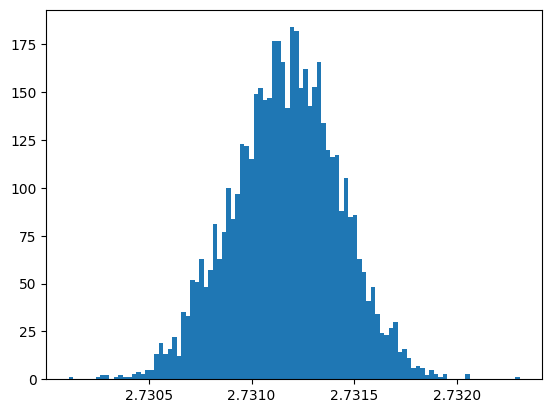

In [13]:
q_0 = 200
T = 10
gamma = 0.001 # permanent impact k
lambd = 0.002 # temporary impact a
alpha = 1e-9 # risk aversion 
sigma = 0.00001 # volatility 
theta_hat = np.sqrt(gamma**2 + 4*alpha*sigma**2*lambd)/(2*lambd)
rho_hat = np.sqrt(gamma**2+12*alpha*sigma**2*lambd)/(6*lambd)
rho_plus = -gamma/(6*lambd) + rho_hat
rho_minus = -gamma/(6*lambd) - rho_hat
a = [q_0,]
for i in range(1,T+1):
    a.append((q_0 )/(2*m.sinh(rho_hat*T)) * (m.exp(rho_hat * T) * m.exp(rho_minus*i) - m.exp(-rho_hat * T) * m.exp(rho_plus*i)))

import modello_QTP_multi_prova as md
numIt = 5000
PASSI = 10
INV = q_0
PERM_IMP = 0.001
TEMP_IMP = 0.002
act = []
re = []
transaction_cost_balance = []
std_list = []
mean_list = []
states = []
ql = []
ac = []
dat = []
VOLA = 0.00001
a_hist = []
k_hist = []
rew = []
for j in range(numIt):
    slices = PASSI

    inv = INV
    tempo = 0
    s_0 = 10
    x = 0
    ke0 = PERM_IMP
    ey0 = TEMP_IMP
    
    x = abs(np.diff(np.asarray(a)))

    for i in range(slices):
        a_hist.append(ey0)
        k_hist.append(ke0)
        k = 0.001 * np.ones(T)
        dati = md.Ambiente(T = 1, sigma = VOLA, S0 = s_0, action = x[i], kappa = k[i]).abm(numIt = 1).flatten()
        selling_strategy = []
        tempo += 1
        s_0 = dati[-1]

        inv = inv-x[i]
        rew.append(- q_0*2 + s_0*x[i] - 0.002*x[i]**2)
        
        a_hist.append(ey0)
        k_hist.append(ke0)
        act.append(x)
        states.append([inv + x, tempo, x])
        selling_strategy.append(x)
        dat.append(dati)
a_hist = np.asarray(    a_hist)
k_hist = np.asarray(    k_hist)

azioni_st = x#/2
dati =  np.asarray(dat)


'''Implementation Shortfalls'''

azioni_st = np.ones((5_000,10)) * x
iss = (2000-(dati[:,0] * azioni_st.flatten() - 0.002 * azioni_st.flatten()**2).reshape(-1,10).sum(axis=1))

print('Agents mean, stddev, median respectively:', remove_outliers(iss).mean(), iss.std(), np.median(iss))

rewards_theo = (dati[:,0] * azioni_st.flatten() - 0.002 * azioni_st.flatten()**2).reshape(-1,10).mean(axis=1)
dati_sch = dati[:,0] 
plt.hist(200-rewards_theo, bins=100);

CONSTRAINED AGENTS


In [14]:
'''Implementation Shortfalls'''
dati =    dict(np.load('C:/Users/macri/Desktop/ennesima/CONSTRAINED_train_10_batch_32/dati.npz', allow_pickle=True)) # non unc
azioni =  dict(np.load('C:/Users/macri/Desktop/ennesima/CONSTRAINED_train_10_batch_32/azioni.npz', allow_pickle=True))

dati = dati['arr_0'][:,0]
azioni1 = azioni['arr_0'][0]#.mean(axis=1)
azioni2 = azioni['arr_0'][1]#.mean(axis=1)
azioni = (azioni1 + azioni2)
iss = []

for i in range(dati.reshape(-1,T).shape[0]):
    iss.append((dati.reshape(-1,T)[i])* azioni[:,i] - 0.002 * azioni[:,i]**2)
    
agents = np.sum((np.asarray(iss)),axis=1)
agents_std = np.sum((np.asarray(iss)),axis=1).std()
print('media IS degli agenti =',  2000-remove_outliers(agents).mean())
print('mediana IS degli agenti =',2000-np.median(agents))
print('stddev IS degli agenti =',agents_std)

rewards = 2000-(dati * azioni.flatten() - 0.002 * azioni.flatten()**2).reshape(T,-1).sum(axis=0)

media IS degli agenti = 24.192036915854715
mediana IS degli agenti = 24.19198626580078
stddev IS degli agenti = 0.3392277349102272


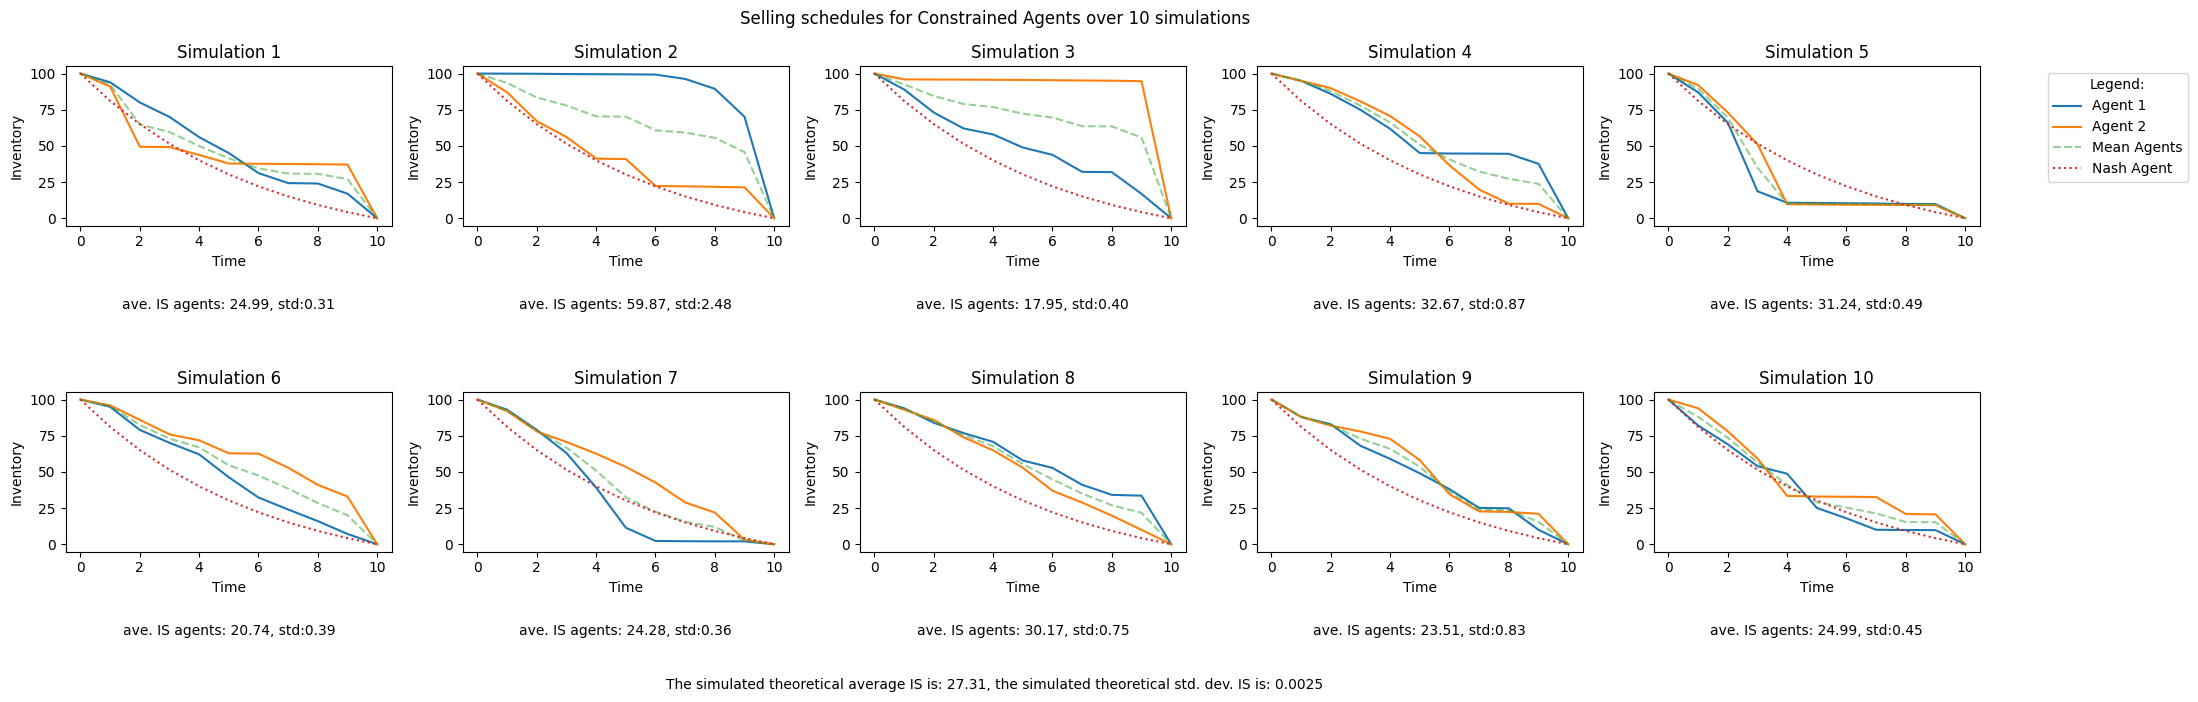

In [15]:
'''Selling Schedules'''

def make_selling_schedule(a, azioni, T, i=0, inv=100):
    azioni_tot_1 = azioni[i, 0]
    azioni_tot_2 = azioni[i, 1]
    agent_1 = azioni_tot_1.mean(axis=1)
    agent_2 = azioni_tot_2.mean(axis=1)
    
    q0_1 = np.zeros(T + 1)
    q0_1[0] = inv
    for j in range(1, T):
        q0_1[j] = q0_1[j - 1] - agent_1[j - 1]
    q0_2 = np.zeros(T + 1)
    q0_2[0] = inv
    for j in range(1, T):
        q0_2[j] = q0_2[j - 1] - agent_2[j - 1]
    q_tot = inv# * 2
    azioni_t = (agent_1 + agent_2) / 2
    qt = np.zeros(T + 1)
    qt[0] = q_tot
    for j in range(1, T):
        qt[j] = qt[j - 1] - azioni_t[j - 1]

    b = np.asarray(a) / 2

    ax.plot(q0_1, label='Agent 1' if i == 0 else None)
    ax.plot(q0_2, label='Agent 2' if i == 0 else None)
    ax.plot(qt, alpha = 0.5, label='Mean Agents' if i == 0 else None, linestyle='--')
    ax.plot(b, label='Nash Agent'if i == 0 else None, linestyle=':')

def do_is(i, dati, azioni, alpha=0.002):
    dati = dati[i,:,0]
    azioni1 =  azioni[i, 0]
    azioni2 =  azioni[i, 0]
    azioni = (azioni1 + azioni2)
    iss = []

    for i in range(dati.reshape(-1,T).shape[0]):
        iss.append((dati.reshape(-1,T)[i])* azioni[:,i] - alpha * azioni[:,i]**2)

    agents = np.sum((np.asarray(iss)),axis=1)
    agents_std = np.sum((np.asarray(iss)),axis=1).std()

    return 2000-remove_outliers(agents).mean(),  agents_std


# Load data
azioni_tot = np.load('C:/Users/macri/Desktop/ennesima/CONSTRAINED_train_10_batch_32/azioni_tot.npy', allow_pickle=True)
dati =       np.load('C:/Users/macri/Desktop/ennesima/CONSTRAINED_train_10_batch_32/dati_tot.npy', allow_pickle=True)
T = len(azioni_tot[0, 0])

# Create subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 7))

# Plot each selling schedule
for i, ax in enumerate(axs.flat):
    make_selling_schedule(a, azioni_tot, T, i, 100)
    ax.set_title(f"Simulation {i+1}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Inventory')
    IS, IS_std = do_is(i, dati, azioni_tot, alpha = 0.002)
    ax.text(0.5, -0.5, f'ave. IS agents: {IS:.2f}, std:{IS_std:.2f}', ha='center', va='center', transform=ax.transAxes)
    #ax.text(0.5, -0.7, f'std. IS agents: {IS_std:.2f}', ha='center', va='center', transform=ax.transAxes)
     
fig.suptitle('Selling schedules for Constrained Agents over 10 simulations')

# Add legend to last subplot
fig.legend(loc='upper right', bbox_to_anchor=(1.1, 0.9), title='Legend:')

# Adjust layout
fig.text(0.5, 0.01, f'The simulated theoretical average IS is: {27.31:.2f}, the simulated theoretical std. dev. IS is: {0.0025:.4f}', ha='center')

plt.tight_layout()
plt.show()

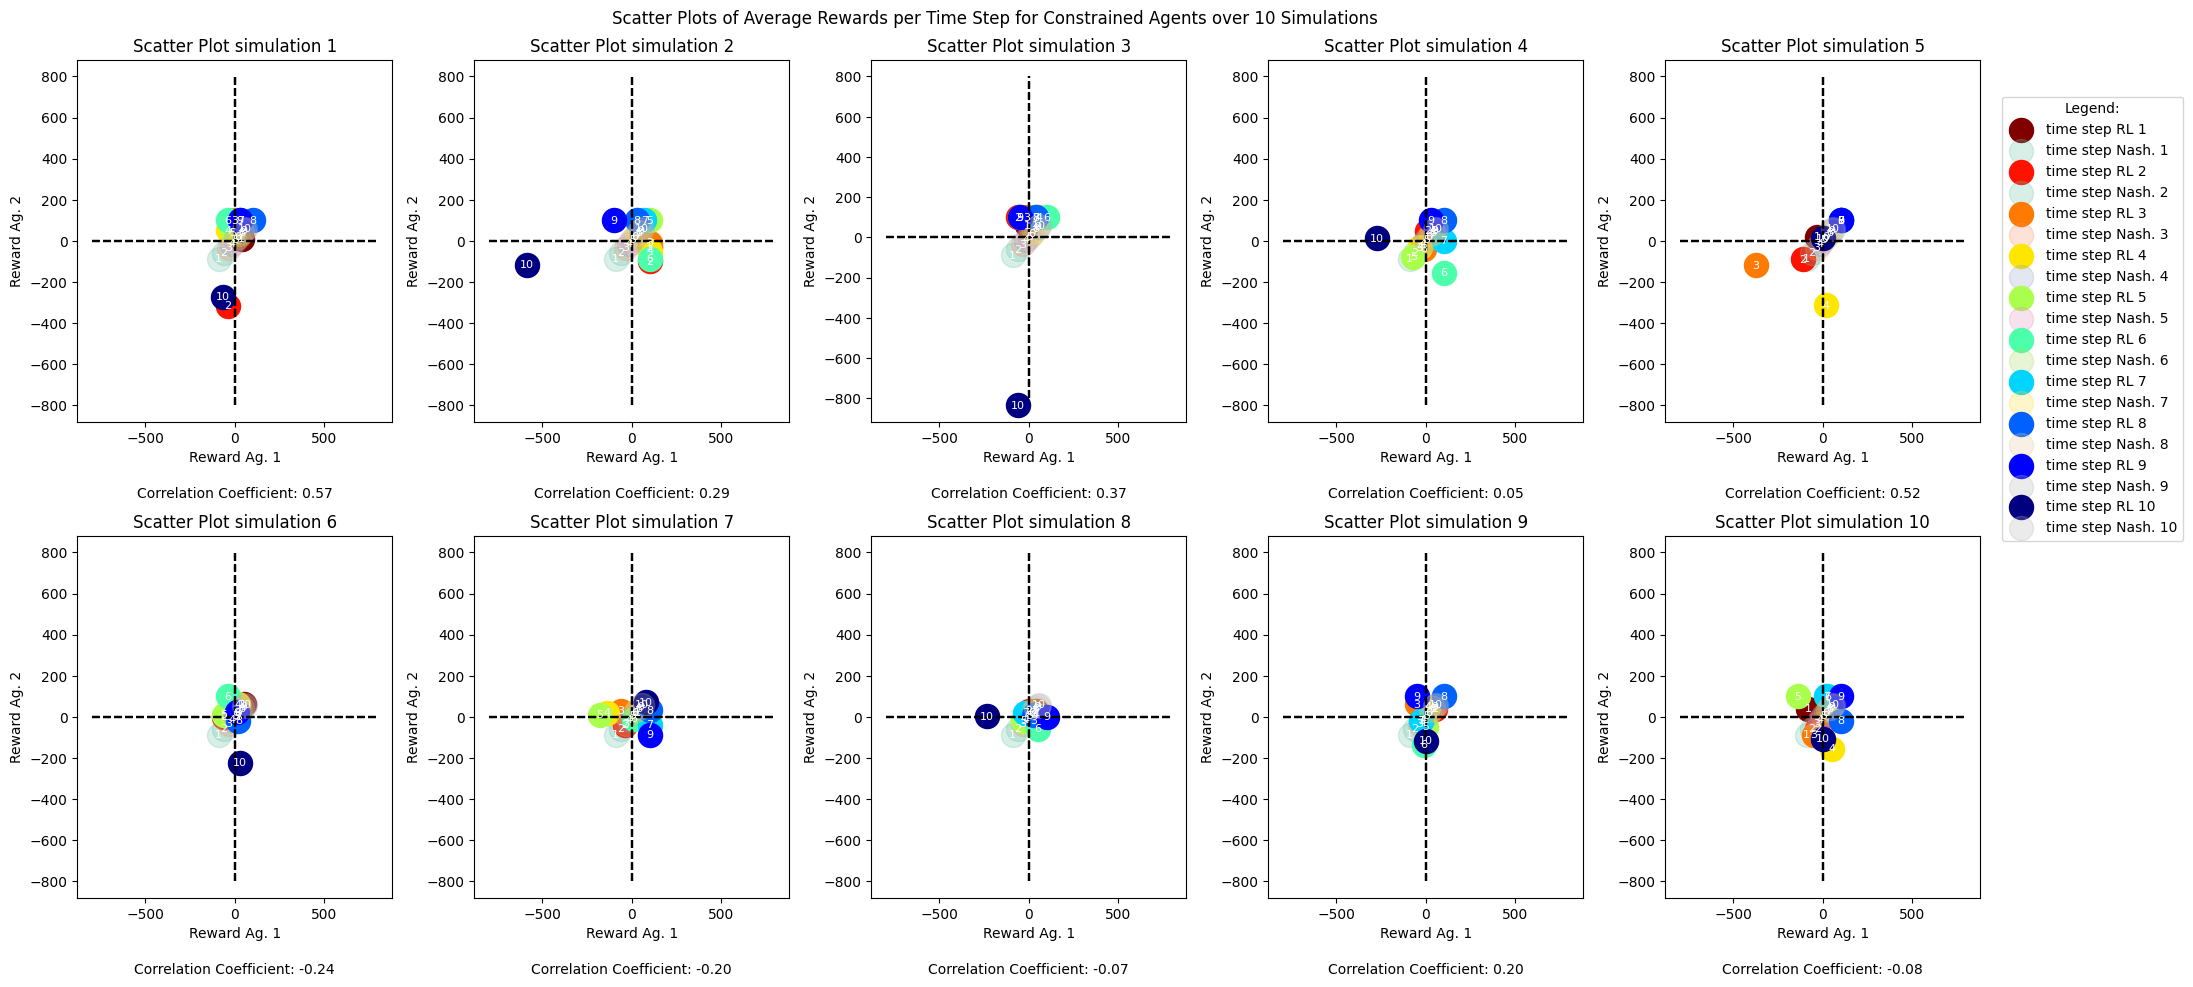

In [16]:
re_tot = np.load('C:/Users/macri/Desktop/ennesima/CONSTRAINED_train_10_batch_32/re_tot.npy')
rewards_sch =  dict(np.load('C:/Users/macri/Desktop/ennesima/THEO_100_inv/re.npz', allow_pickle=True))
rewards_per_simulation(re_tot, rewards_sch, axis_control=False, cons = True)

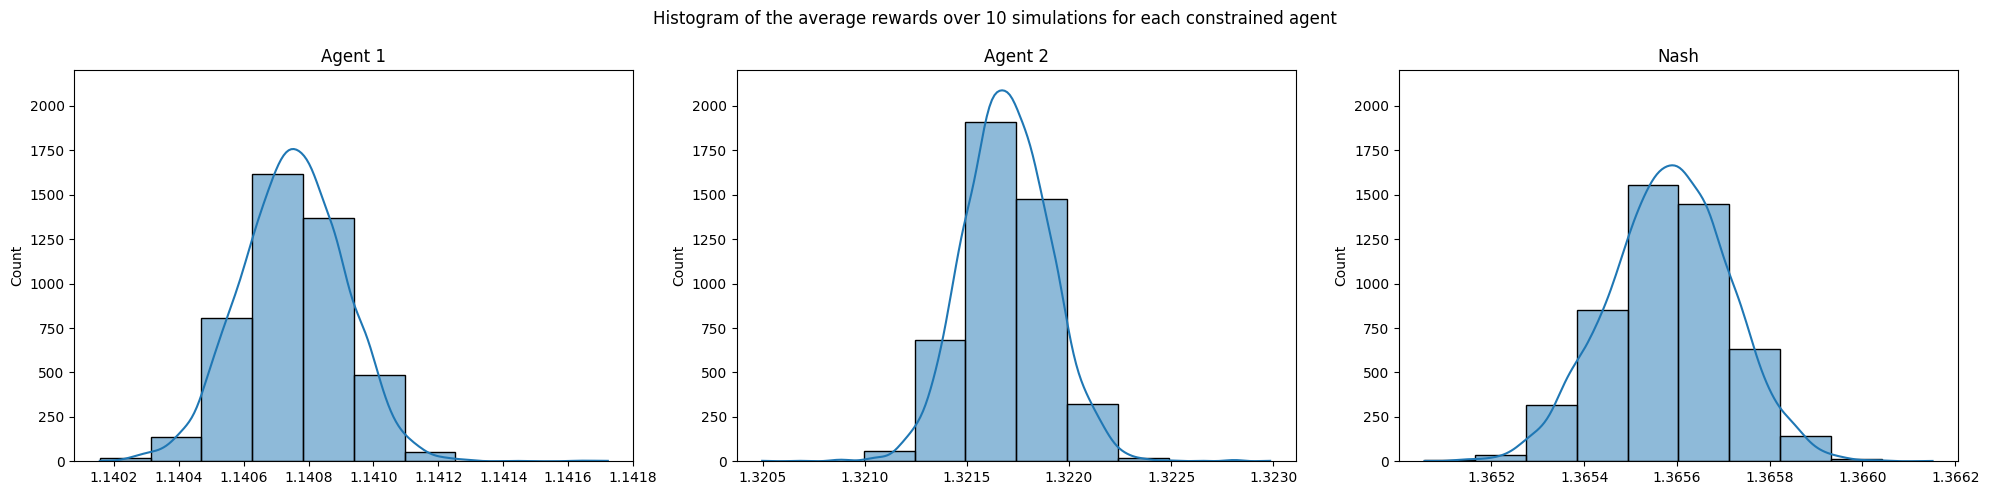

 The Wasserstein distance between RL agents and the Nash agents is: 0.267762
 The 2-norm distance between RL agents and the Nash agents is: 19.136087


In [17]:
rewards = (np.load('C:/Users/macri/Desktop/ennesima/CONSTRAINED_train_10_batch_32/re_tot.npy', allow_pickle=True))

# Create a grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot the first histogram
sns.histplot(remove_outliers(rewards[:][0].mean(axis = 0).mean(axis=0)), bins=10, kde=True, ax=axs[0])
axs[0].set_title('Agent 1')
axs[0].set_ylim(0, 2200)

# Plot the second histogram
sns.histplot(remove_outliers(rewards[:][1].mean(axis = 0).mean(axis=0)), bins=10, kde=True, ax=axs[1])
axs[1].set_title('Agent 2')
axs[1].set_ylim(0, 2200)

# Plot the third histogram
sns.histplot((200-rewards_theo)/2, bins=10, kde=True, ax=axs[2])
axs[2].set_title('Nash')
axs[2].set_ylim(0, 2200)

#axs.set_ylim(0, 2000)
fig.suptitle('Histogram of the average rewards over 10 simulations for each constrained agent')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

agente_1 = (rewards[:][0].mean(axis = 0).mean(axis=0))
agente_2 = (rewards[:][1].mean(axis = 0).mean(axis=0))
theo = (200-rewards_theo)

print(f' The Wasserstein distance between RL agents and the Nash agents is: {wasserstein_distance(agente_1 + agente_2, theo):2f}')
print(f' The 2-norm distance between RL agents and the Nash agents is: {np.linalg.norm((agente_1+agente_2) - theo):2f}')


UNCONTRAINED AGENTS

In [18]:
'''Implementation Shortfalls'''
dati =    dict(np.load('C:/Users/macri/Desktop/ennesima/train_10_batch_32/dati.npz', allow_pickle=True)) # non unc
azioni =  dict(np.load('C:/Users/macri/Desktop/ennesima/train_10_batch_32/azioni.npz', allow_pickle=True))

dati = dati['arr_0'][:,0]
azioni1 = azioni['arr_0'][0]#.mean(axis=1)
azioni2 = azioni['arr_0'][1]#.mean(axis=1)
azioni = (azioni1 + azioni2)
iss = []

for i in range(dati.reshape(-1,T).shape[0]):
    iss.append((dati.reshape(-1,T)[i])* azioni[:,i] - 0.002 * azioni[:,i]**2)
    
agents = np.sum((np.asarray(iss)),axis=1)
agents_std = np.sum((np.asarray(iss)),axis=1).std()
print('media IS degli agenti =',  2000-remove_outliers(agents).mean())
print('mediana IS degli agenti =',2000-np.median(agents))
print('stddev IS degli agenti =',agents_std)

rewards = 2000-(dati * azioni.flatten() - 0.002 * azioni.flatten()**2).reshape(T,-1).sum(axis=0)

media IS degli agenti = 24.576002956774573
mediana IS degli agenti = 24.57618850099948
stddev IS degli agenti = 0.39432130759170575


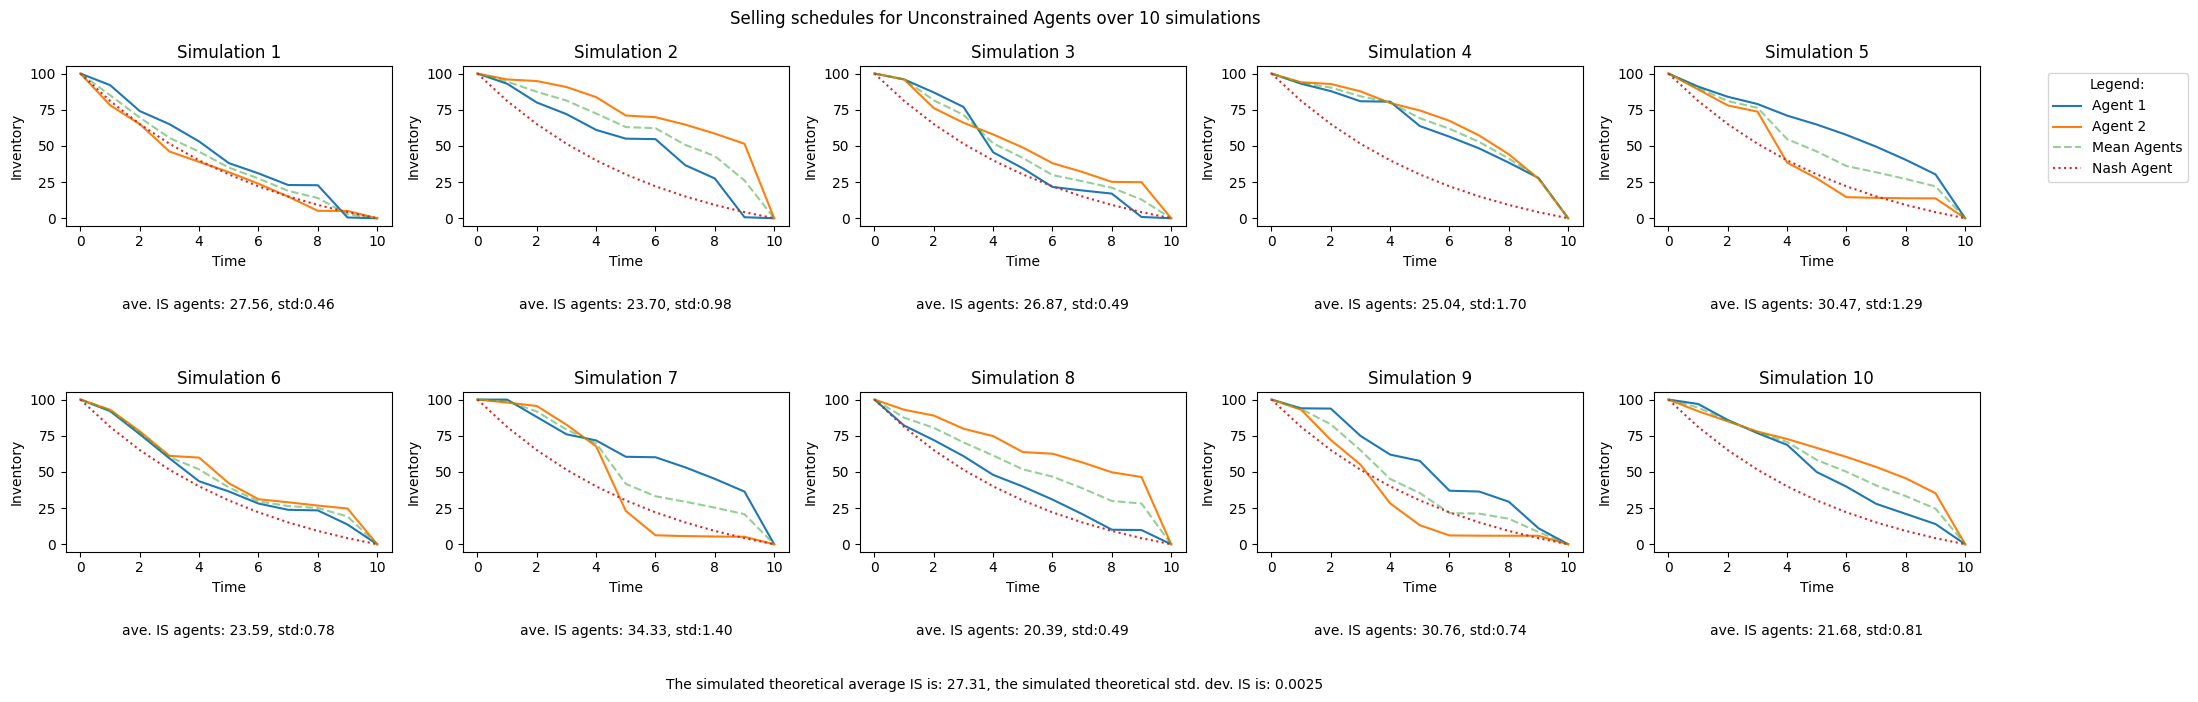

In [19]:
'''Selling Schedules'''

def make_selling_schedule(a, azioni, T, i=0, inv=100):
    azioni_tot_1 = azioni[i, 0]
    azioni_tot_2 = azioni[i, 1]
    agent_1 = azioni_tot_1.mean(axis=1)
    agent_2 = azioni_tot_2.mean(axis=1)
    
    q0_1 = np.zeros(T + 1)
    q0_1[0] = inv
    for j in range(1, T):
        q0_1[j] = q0_1[j - 1] - agent_1[j - 1]
    q0_2 = np.zeros(T + 1)
    q0_2[0] = inv
    for j in range(1, T):
        q0_2[j] = q0_2[j - 1] - agent_2[j - 1]
    q_tot = inv# * 2
    azioni_t = (agent_1 + agent_2) / 2
    qt = np.zeros(T + 1)
    qt[0] = q_tot
    for j in range(1, T):
        qt[j] = qt[j - 1] - azioni_t[j - 1]

    b = np.asarray(a) / 2

    ax.plot(q0_1, label='Agent 1' if i == 0 else None)
    ax.plot(q0_2, label='Agent 2' if i == 0 else None)
    ax.plot(qt, alpha = 0.5, label='Mean Agents' if i == 0 else None, linestyle='--')
    ax.plot(b, label='Nash Agent'if i == 0 else None, linestyle=':')

def do_is(i, dati, azioni, alpha=0.002):
    dati = dati[i,:,0]
    azioni1 =  azioni[i, 0]
    azioni2 =  azioni[i, 0]
    azioni = (azioni1 + azioni2)
    iss = []

    for i in range(dati.reshape(-1,T).shape[0]):
        iss.append((dati.reshape(-1,T)[i])* azioni[:,i] - alpha * azioni[:,i]**2)

    agents = np.sum((np.asarray(iss)),axis=1)
    agents_std = np.sum((np.asarray(iss)),axis=1).std()

    return 2000-remove_outliers(agents).mean(),  agents_std


# Load data
azioni_tot = np.load('C:/Users/macri/Desktop/ennesima/train_10_batch_32/azioni_tot.npy', allow_pickle=True)
dati =       np.load('C:/Users/macri/Desktop/ennesima/train_10_batch_32/dati_tot.npy', allow_pickle=True)
T = len(azioni_tot[0, 0])

# Create subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 7))

# Plot each selling schedule
for i, ax in enumerate(axs.flat):
    make_selling_schedule(a, azioni_tot, T, i, 100)
    ax.set_title(f"Simulation {i+1}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Inventory')
    IS, IS_std = do_is(i, dati, azioni_tot, alpha = 0.002)
    ax.text(0.5, -0.5, f'ave. IS agents: {IS:.2f}, std:{IS_std:.2f}', ha='center', va='center', transform=ax.transAxes)
    #ax.text(0.5, -0.7, f'std. IS agents: {IS_std:.2f}', ha='center', va='center', transform=ax.transAxes)
     
fig.suptitle('Selling schedules for Unconstrained Agents over 10 simulations')

# Add legend to last subplot
fig.legend(loc='upper right', bbox_to_anchor=(1.1, 0.9), title='Legend:')

# Adjust layout
fig.text(0.5, 0.01, f'The simulated theoretical average IS is: {27.31:.2f}, the simulated theoretical std. dev. IS is: {0.0025:.4f}', ha='center')

plt.tight_layout()
plt.show()

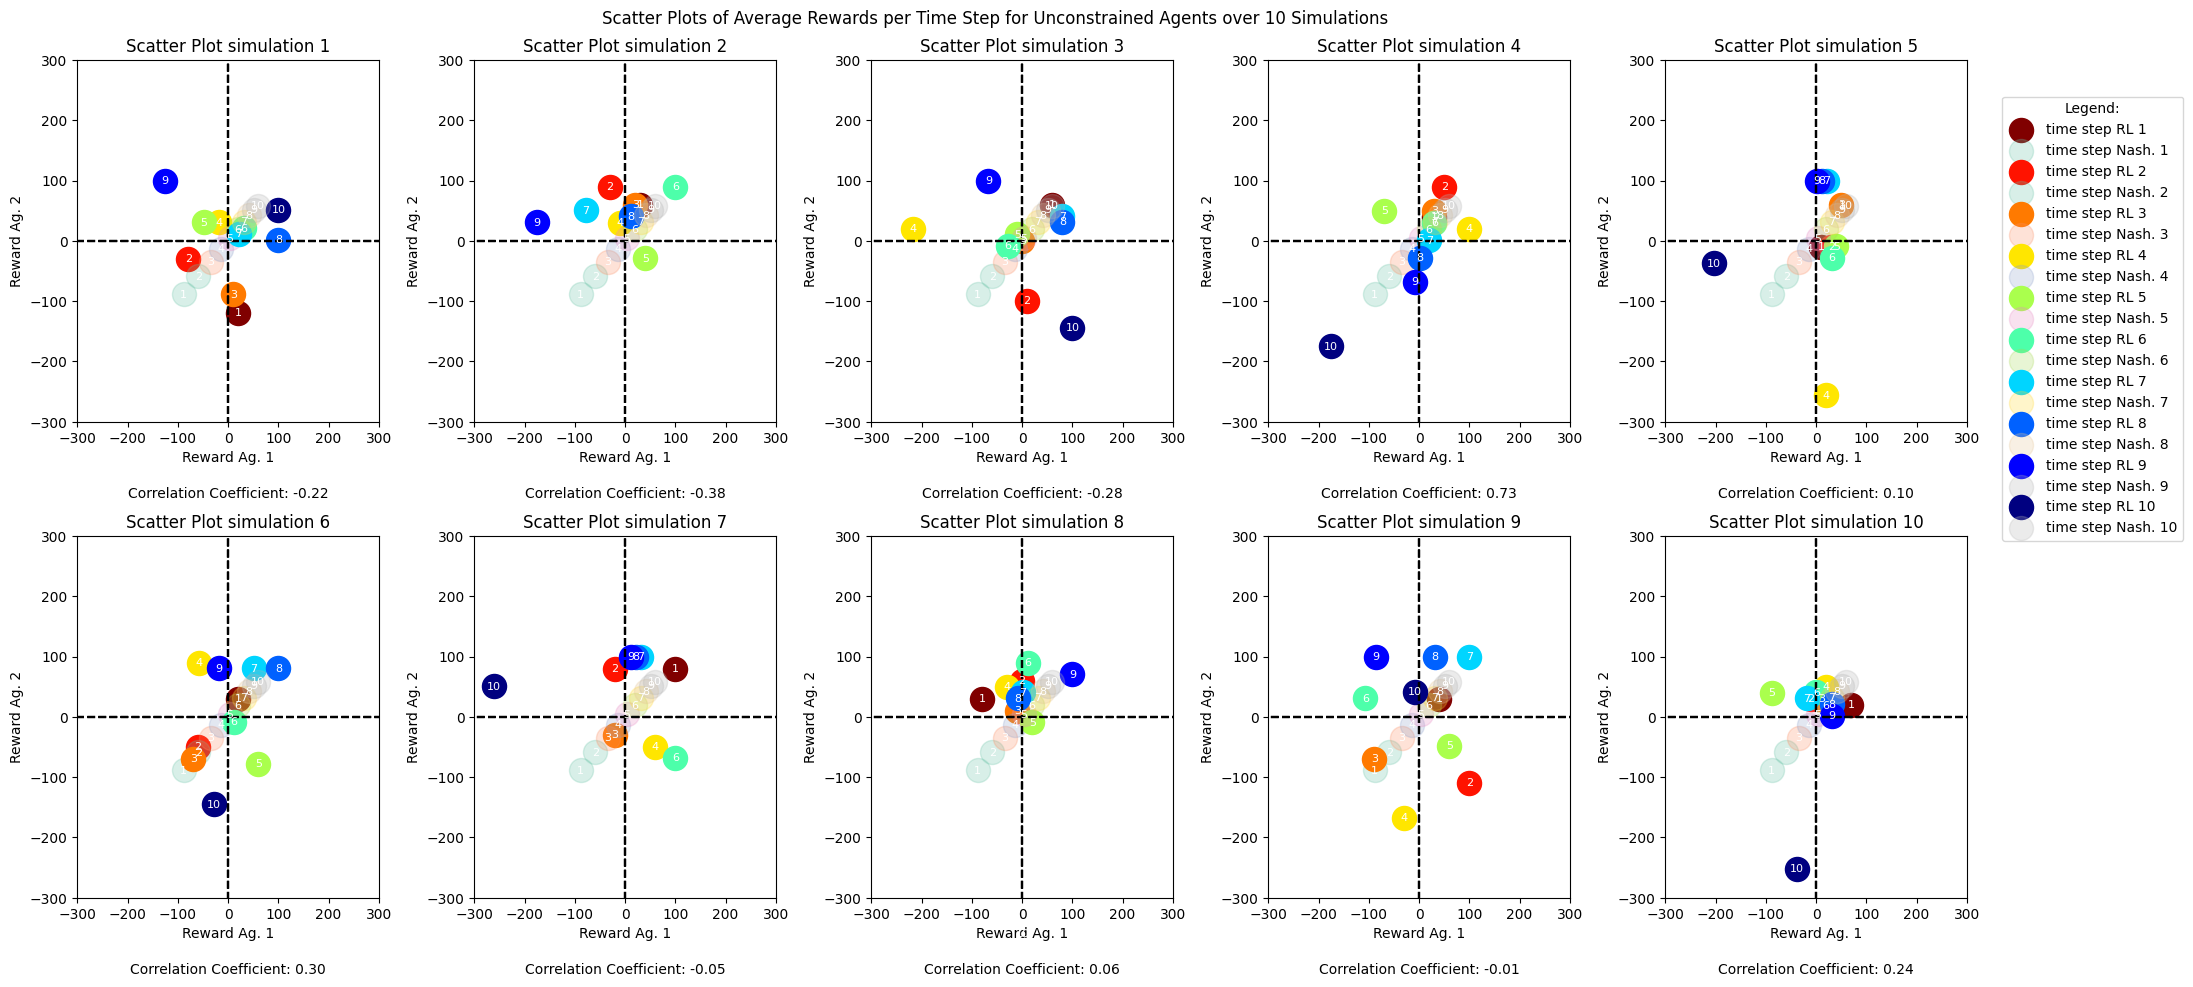

In [20]:
re_tot = np.load('C:/Users/macri/Desktop/ennesima/train_10_batch_32/re_tot.npy')
rewards_sch =  dict(np.load('C:/Users/macri/Desktop/ennesima/THEO_100_inv/re.npz', allow_pickle=True))
rewards_per_simulation(re_tot, rewards_sch, axis_control=True)

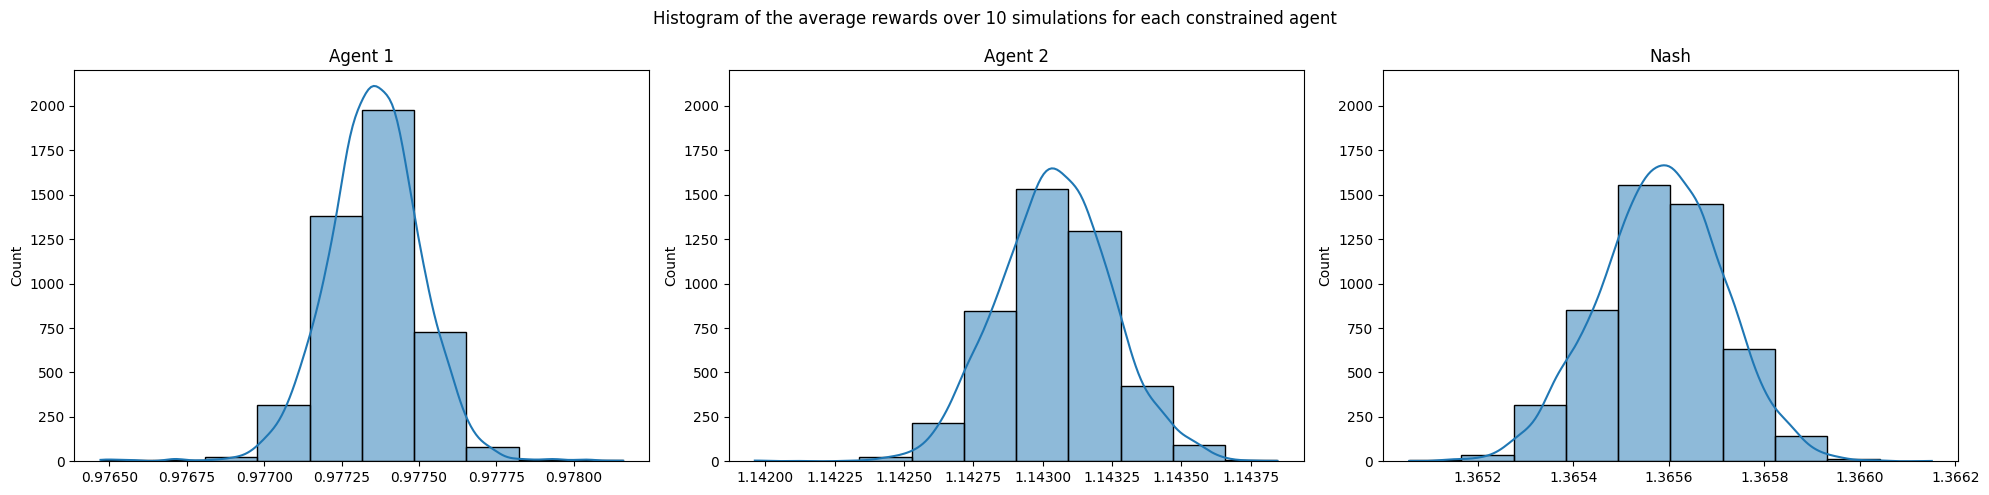

 The Wasserstein distance between RL agents and the Nash agents is: 0.610952
 The 2-norm distance between RL agents and the Nash agents is: 43.227229


In [21]:
rewards = (np.load('C:/Users/macri/Desktop/ennesima/train_10_batch_32/re_tot.npy', allow_pickle=True))

# Create a grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot the first histogram
sns.histplot(remove_outliers(rewards[:][0].mean(axis = 0).mean(axis=0)), bins=10, kde=True, ax=axs[0])
axs[0].set_title('Agent 1')
axs[0].set_ylim(0, 2200)

# Plot the second histogram
sns.histplot(remove_outliers(rewards[:][1].mean(axis = 0).mean(axis=0)), bins=10, kde=True, ax=axs[1])
axs[1].set_title('Agent 2')
axs[1].set_ylim(0, 2200)

# Plot the third histogram
sns.histplot((200-rewards_theo)/2, bins=10, kde=True, ax=axs[2])
axs[2].set_title('Nash')
axs[2].set_ylim(0, 2200)

#axs.set_ylim(0, 2000)
fig.suptitle('Histogram of the average rewards over 10 simulations for each constrained agent')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

agente_1 = (rewards[:][0].mean(axis = 0).mean(axis=0))
agente_2 = (rewards[:][1].mean(axis = 0).mean(axis=0))
theo = (200-rewards_theo)

print(f' The Wasserstein distance between RL agents and the Nash agents is: {wasserstein_distance(agente_1 + agente_2, theo):2f}')
print(f' The 2-norm distance between RL agents and the Nash agents is: {np.linalg.norm((agente_1+agente_2) - theo):2f}')